In [0]:
# libraries

import tensorflow         as     tf

from   tensorflow         import keras

from   tensorflow         import contrib

from   tensorflow.contrib import autograph

import numpy             as np

import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# parameters

DATA_NUM_CLASSES = 10

MODEL_LEVEL_0_BLOCKS = 4

MODEL_LEVEL_1_BLOCKS = 6

MODEL_LEVEL_2_BLOCKS = 3

TRAINING_IMAGE_SIZE        = 32

TRAINING_CROP_SIZE         = 28

TRAINING_SHUFFLE_BUFFER    = 5000

TRAINING_BATCH_SIZE        = 32

TRAINING_NUM_EPOCHS        = 100

#TRAINING_MOMENTUM          = 0.9                    

#TRAINING_REGULARIZER_SCALE = 0.1                    

TRAINING_LR_INITIAL        = 0.001

TRAINING_LR_SCALE          = 0.1

TRAINING_LR_EPOCHS         = 48

TRAINING_LR_STAIRCASE      = True

TRAINING_MAX_CHECKPOINTS   = 5

#TRAINING_CHECKPOINT_FILE   = './logs/model_{}.ckpt' 

In [0]:
# functions

def center_crop(image, crop_height, crop_width):

    shape  = tf.shape(image)

    height = shape[0]

    width  = shape[1]

    amount_to_be_cropped_h = (height - crop_height)

    crop_top               = amount_to_be_cropped_h // 2

    amount_to_be_cropped_w = (width - crop_width)

    crop_left              = amount_to_be_cropped_w // 2
    
    return tf.slice(image, [crop_top, crop_left, 0], [crop_height, crop_width, -1])


def pre_processing_train(image, label):

    image = tf.image.random_flip_left_right(image)

    image = tf.random_crop(image, size=[TRAINING_CROP_SIZE, TRAINING_CROP_SIZE, 3])

    image = tf.math.divide(tf.math.subtract(tf.cast(image, tf.float32), data_mean), data_std)    

    return image, label
  
  
def pre_processing_test(image, label):
  
    image = center_crop(image, TRAINING_CROP_SIZE, TRAINING_CROP_SIZE)

    image = tf.math.divide(tf.math.subtract(tf.cast(image, tf.float32), data_mean), data_std)

    return image, label

In [4]:
# dataset processing

cifar10 = keras.datasets.cifar10

(data_train, labels_train), (data_test, labels_test) = cifar10.load_data()

data_mean = np.mean(data_train, axis=tuple(range(data_train.ndim - 1)), dtype=np.float32).reshape((1, 1, 3))

data_std  = np.std(data_train,  axis=tuple(range(data_train.ndim - 1)), dtype=np.float32).reshape((1, 1, 3))



labels_train = labels_train.astype(np.int32)

labels_test  = labels_test.astype(np.int32)

labels_train = np.squeeze(labels_train)

labels_test  = np.squeeze(labels_test)



dataset_train = tf.data.Dataset.from_tensor_slices((data_train, labels_train))

dataset_test  = tf.data.Dataset.from_tensor_slices((data_test,  labels_test))

dataset_train = dataset_train.shuffle(TRAINING_SHUFFLE_BUFFER).repeat().map(pre_processing_train).batch(TRAINING_BATCH_SIZE)

dataset_test  = dataset_test.repeat().map(pre_processing_test).batch(TRAINING_BATCH_SIZE)



print(data_train.shape)

print(data_test.shape)

print(labels_train.shape)

print(labels_test.shape)



170500096/170498071 [==============================] - 16s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000,)
(10000,)


In [0]:
iterator            = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)

iterator_init_train = iterator.make_initializer(dataset_train)

iterator_init_test  = iterator.make_initializer(dataset_test)

data, labels = iterator.get_next()

In [0]:
# our model - sequential

def model_sequential(data, train_state, num_classes): 

    fm       = tf.layers.conv2d(data, 32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    fm       = tf.layers.conv2d(fm,   32, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')

    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    fm       = tf.layers.conv2d(fm,   64, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    fm       = tf.layers.max_pooling2d(fm, (3, 3), (2, 2), padding='same', data_format='channels_last')
    
    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    fm       = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)

    features = tf.layers.conv2d(fm,   128, (3, 3), strides=(1, 1), padding='same', data_format='channels_last', dilation_rate=(1, 1), activation=tf.nn.relu, use_bias=True)
    
    print("features here ->")

    print(features);

    features    = tf.reduce_mean(features, axis=[1, 2])

    predictions = tf.layers.dense(features, num_classes, activation=None, use_bias=True)    

    return predictions

In [8]:
#Training

train_state = tf.placeholder(tf.bool, name='train_state')

num_train         = len(data_train)

num_test          = len(data_test)

num_batches_train = int(num_train/TRAINING_BATCH_SIZE)

num_batches_test  = int(num_test/TRAINING_BATCH_SIZE)

print(num_train)

print(num_test)

print(num_batches_train)

print(num_batches_test)



# model

# predictions      = model_sequential(data, train_state, DATA_NUM_CLASSES)

# predictions      = model_sequential_bn(data, train_state, DATA_NUM_CLASSES)

predictions      = model_sequential(data, train_state,DATA_NUM_CLASSES)

predictions_test = np.zeros((num_test, DATA_NUM_CLASSES), dtype=np.float32)

accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.cast(labels, tf.int64)), tf.float32))

loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=predictions)



# optimizer

global_step   = tf.Variable(0, trainable=False)

learning_rate = tf.train.exponential_decay(TRAINING_LR_INITIAL, global_step, TRAINING_LR_EPOCHS*num_batches_train, TRAINING_LR_SCALE, staircase=TRAINING_LR_STAIRCASE)

update_ops    = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # optimizer = tf.train.MomentumOptimizer(learning_rate, TRAINING_MOMENTUM, use_nesterov=True).minimize(loss, global_step=global_step)



# saver

# saver = tf.train.Saver(max_to_keep=TRAINING_MAX_CHECKPOINTS)



# create a session

session = tf.Session()

    

# initialize global variables

session.run(tf.global_variables_initializer())



# cycle through the epochs

for epoch_index in range(TRAINING_NUM_EPOCHS):

    

    # train

    # initialize the iterator to the training dataset

    # cycle through the training batches

    # example, encoder, decoder, error, gradient computation and update

    session.run(iterator_init_train)

    for batch_index in range(num_batches_train):

        session.run(optimizer, feed_dict={train_state: True})



    # validate

    # initialize the iterator to the testing dataset

    # reset the accuracy statistics

    # cycle through the testing batches

    # example, encoder, decoder, accuracy

    session.run(iterator_init_test)

    num_correct = 0

    for batch_index in range(num_batches_test):

        num_correct_batch, predictions_batch    = session.run([accuracy, predictions], feed_dict={train_state: False})

        num_correct                            += num_correct_batch

        row_start                               = batch_index*TRAINING_BATCH_SIZE

        row_end                                 = (batch_index + 1)*TRAINING_BATCH_SIZE

        predictions_test[row_start:row_end, :]  = predictions_batch



    # display

    print('Epoch {0:3d}: accuracy is {1:5.2f} %'.format(epoch_index, (100.0*num_correct)/(TRAINING_BATCH_SIZE*num_batches_test)))



    # save

    # saver.save(session, TRAINING_CHECKPOINT_FILE.format(epoch_index))



# close the session

session.close()

50000
10000
1562
312
features here ->
Tensor("conv2d_17/Relu:0", shape=(?, 7, 7, 128), dtype=float32)
Epoch   0: accuracy is 52.36 %
Epoch   1: accuracy is 65.70 %
Epoch   2: accuracy is 70.20 %
Epoch   3: accuracy is 72.71 %
Epoch   4: accuracy is 73.73 %
Epoch   5: accuracy is 77.46 %
Epoch   6: accuracy is 79.10 %
Epoch   7: accuracy is 78.55 %
Epoch   8: accuracy is 79.22 %
Epoch   9: accuracy is 80.17 %
Epoch  10: accuracy is 80.03 %
Epoch  11: accuracy is 80.98 %
Epoch  12: accuracy is 81.48 %
Epoch  13: accuracy is 81.79 %
Epoch  14: accuracy is 81.04 %
Epoch  15: accuracy is 82.17 %
Epoch  16: accuracy is 82.21 %
Epoch  17: accuracy is 80.66 %
Epoch  18: accuracy is 81.78 %
Epoch  19: accuracy is 81.40 %
Epoch  20: accuracy is 81.45 %
Epoch  21: accuracy is 82.15 %
Epoch  22: accuracy is 81.45 %
Epoch  23: accuracy is 81.17 %
Epoch  24: accuracy is 81.64 %
Epoch  25: accuracy is 83.54 %
Epoch  26: accuracy is 82.50 %
Epoch  27: accuracy is 82.01 %
Epoch  28: accuracy is 82.42 %

Predicted label: 3 and actual label: 3


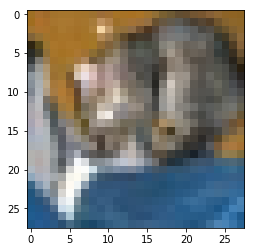

Predicted label: 8 and actual label: 8


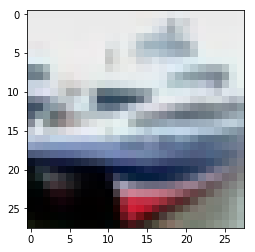

Predicted label: 8 and actual label: 8


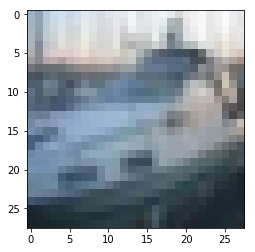

Predicted label: 0 and actual label: 0


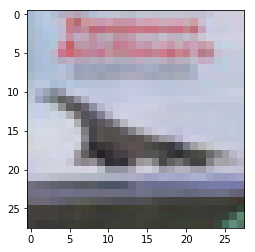

Predicted label: 6 and actual label: 6


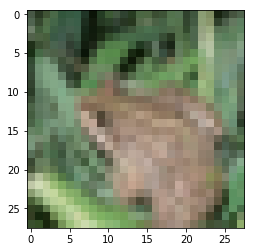

Predicted label: 6 and actual label: 6


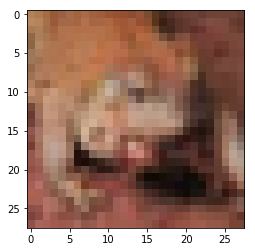

Predicted label: 1 and actual label: 1


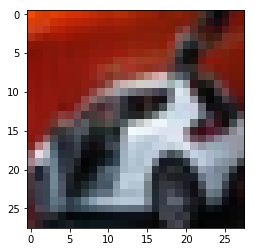

Predicted label: 2 and actual label: 6


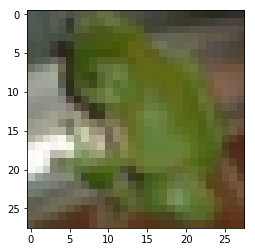

Predicted label: 3 and actual label: 3


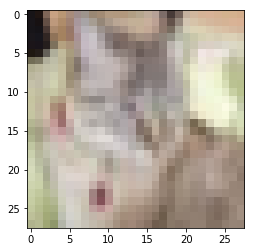

Predicted label: 1 and actual label: 1


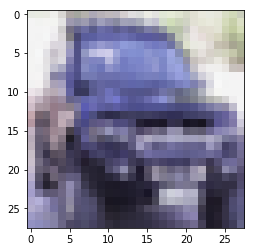

Predicted label: 0 and actual label: 0


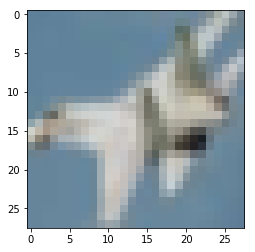

Predicted label: 9 and actual label: 9


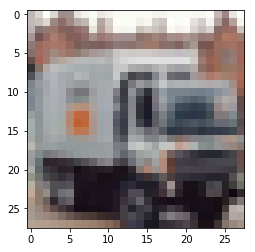

Predicted label: 4 and actual label: 5


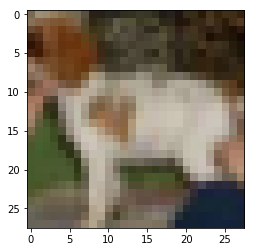

Predicted label: 7 and actual label: 7


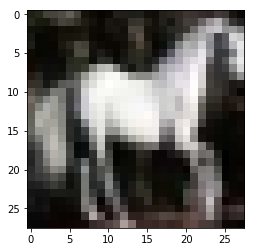

Predicted label: 9 and actual label: 9


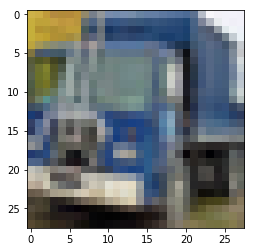

Predicted label: 8 and actual label: 8


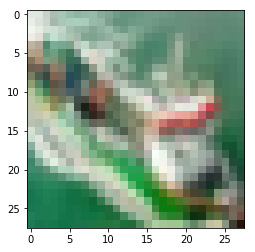

Predicted label: 5 and actual label: 5


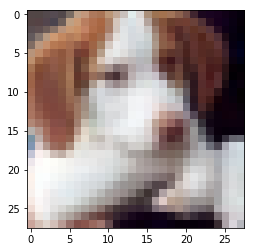

Predicted label: 7 and actual label: 7


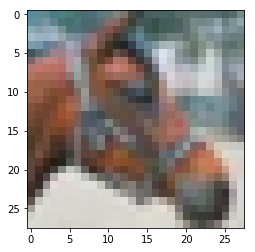

Predicted label: 8 and actual label: 8


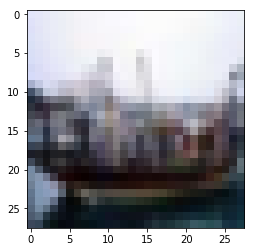

Predicted label: 6 and actual label: 6


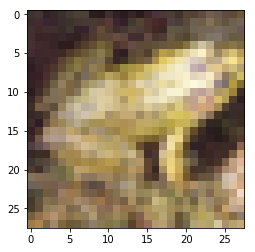

Predicted label: 7 and actual label: 7


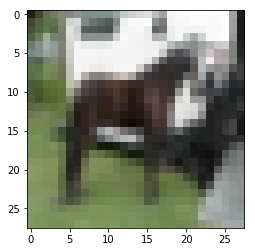

Predicted label: 0 and actual label: 0


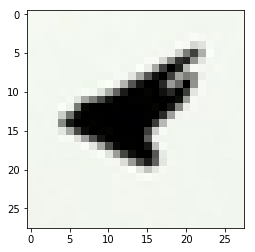

Predicted label: 4 and actual label: 4


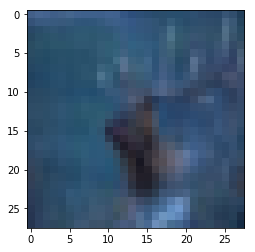

Predicted label: 9 and actual label: 9


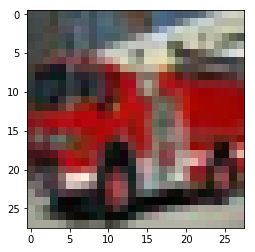

Predicted label: 5 and actual label: 5


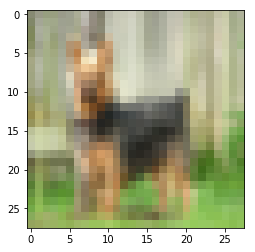

Predicted label: 2 and actual label: 2


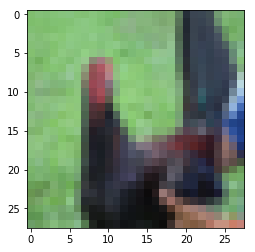

Predicted label: 5 and actual label: 4


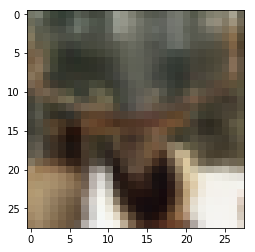

Predicted label: 0 and actual label: 0


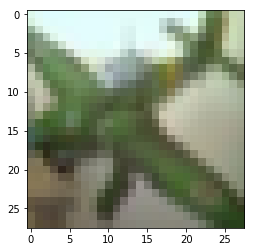

Predicted label: 9 and actual label: 9


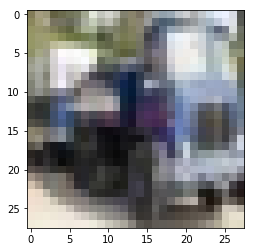

Predicted label: 6 and actual label: 6


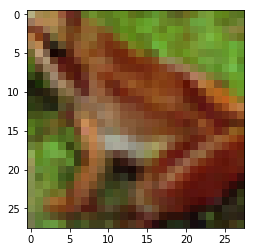

Predicted label: 6 and actual label: 6


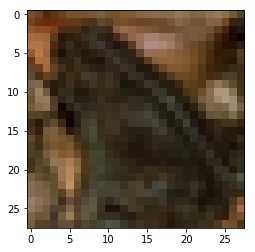

Predicted label: 5 and actual label: 5


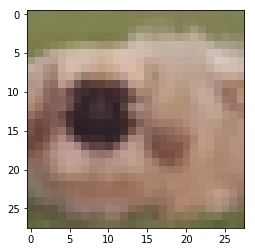

In [9]:
# create session

session = tf.Session()



# initialize global variables

session.run(tf.global_variables_initializer())



# initialize the test iterator

session.run(iterator_init_test)



# cycle through a few batches

for batch_index in range(1):

    

    # generate data and labels

    data_batch, labels_batch = session.run([data, labels])

    

    # normalize to [0, 1]

    data_batch = ((data_batch*data_std.reshape((1, 1, 1, 3))) + data_mean.reshape((1, 1, 1, 3)))/255.0;

    

    # convert the final saved predictions to labels

    row_start          = batch_index*TRAINING_BATCH_SIZE

    row_end            = (batch_index + 1)*TRAINING_BATCH_SIZE

    predictions_labels = np.argmax(predictions_test[row_start:row_end, :], axis=1)

    

    # cycle through the images in the batch

    for image_index in range(TRAINING_BATCH_SIZE):

        

        # display the predicted label, actual label and image

        print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predictions_labels[image_index], labels_batch[image_index]))

        plt.imshow(data_batch[image_index, :, :, :])

        plt.show()



# close the session

session.close()